In [1]:
import pandas as pd

#读取attr表格
attrs = pd.read_csv('../datas/celeba/attrs.csv', sep=',')

attrs.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [2]:
import os
import shutil


#按照attr复制图片到各个文件夹中,这会让数据集的体积膨胀约8倍
def copy_image_to_class():
    for clazz in attrs.columns[1:6]:
        to_folder = '../datas/celeba/image_to_class/' + clazz
        #shutil.rmtree(to_folder, ignore_errors=True)
        os.makedirs(to_folder, exist_ok=True)

        for file in attrs['filename'][attrs[clazz] == 1]:
            copy_from = '../datas/celeba/images/' + file
            copy_to = to_folder + '/' + file

            if os.path.exists(copy_to):
                continue

            shutil.copyfile(copy_from, copy_to)

        print(clazz)


copy_image_to_class()

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald


In [3]:
import keras

datas = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

datas = datas.flow_from_directory('../datas/celeba/image_to_class',
                                  target_size=(64, 64),
                                  batch_size=64,
                                  shuffle=True,
                                  class_mode='input')

len(datas), datas[0][0].shape

Using TensorFlow backend.


Found 226432 images belonging to 5 classes.


(3538, (64, 64, 64, 3))

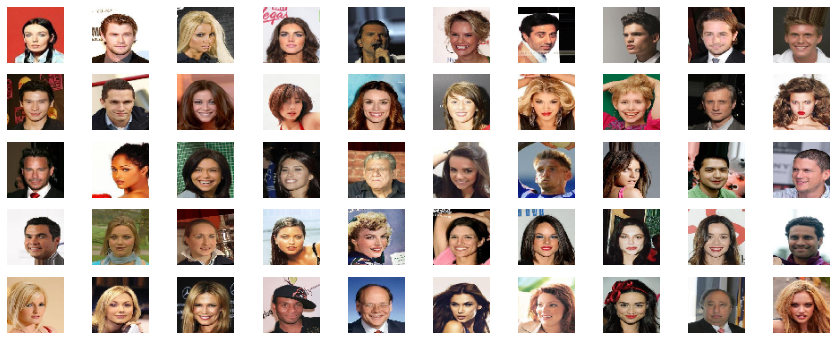

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline


def show(images):
    plt.figure(figsize=(15, 6))

    for i in range(len(images)):
        plt.subplot(5, 10, i + 1)
        plt.imshow((images[i] + 1) / 2)
        plt.axis('off')

    plt.show()


show(datas[0][0][:50])

In [5]:
weight_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

cls = keras.models.Sequential([
    keras.layers.Conv2D(filters=64,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init,
                        input_shape=(64, 64, 3)),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=128,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=256,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2D(filters=512,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation=None, kernel_initializer=weight_init),
])

gen = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 512,
                       kernel_initializer=weight_init,
                       input_shape=(100, )),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Reshape((4, 4, 512)),
    keras.layers.Conv2DTranspose(filters=256,
                                 kernel_size=5,
                                 padding='same',
                                 strides=2,
                                 kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2DTranspose(filters=128,
                                 kernel_size=5,
                                 padding='same',
                                 strides=2,
                                 kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2DTranspose(filters=64,
                                 kernel_size=5,
                                 padding='same',
                                 strides=2,
                                 kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Conv2DTranspose(filters=3,
                                 kernel_size=5,
                                 padding='same',
                                 strides=2,
                                 kernel_initializer=weight_init),
    keras.layers.Activation('tanh'),
])

cls, gen

(<keras.engine.sequential.Sequential at 0x7f8354d9f4e0>,
 <keras.engine.sequential.Sequential at 0x7f8354c9dbe0>)

In [6]:
def set_trainable(model, trainable):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable


def wasserstein(y_true, y_pred):
    return -keras.backend.mean(y_true * y_pred)

In [7]:
set_trainable(cls, False)
set_trainable(gen, True)

gan = keras.models.Sequential([gen, cls])
gan.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
            loss=wasserstein)

set_trainable(cls, True)
set_trainable(gen, True)

gan

In [8]:
from functools import partial
import numpy as np


def get_cls_model():

    set_trainable(cls, True)
    set_trainable(gen, False)

    #真实的输入图片数据
    input_cls = keras.layers.Input(shape=(64, 64, 3))

    #让gen随机生成假图片
    input_gen = keras.layers.Input(shape=(100, ))
    output_gen = gen(input_gen)

    #分别计算分类结果
    output_cls_real = cls(input_cls)
    output_cls_fake = cls(output_gen)

    #融合两类图片
    class RandomWeightedAverage(keras.layers.merge._Merge):

        def __init__(self):
            super().__init__()

        def _merge_function(self, inputs):
            alpha = keras.backend.random_uniform((64, 1, 1, 1))
            return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    input_merge = RandomWeightedAverage()([input_cls, output_gen])

    #计算融合图片的分类
    output_merge = cls(input_merge)

    #以梯度作为loss
    def gradient_penalty_loss(y_true, y_pred, input):
        grads = keras.backend.gradients(y_pred, input)[0]
        grads = keras.backend.square(grads)
        grads = keras.backend.sum(grads, axis=np.arange(1, len(grads.shape)))
        grads = keras.backend.sqrt(grads)
        grads = keras.backend.square(1 - grads)
        return keras.backend.mean(grads)

    loss_merge = partial(gradient_penalty_loss, input=input_merge)

    #输入是两类图片,输出是3个分类结果.融合图是自己计算出来的.
    cls_model = keras.models.Model(
        inputs=[input_cls, input_gen],
        outputs=[output_cls_real, output_cls_fake, output_merge])

    #我也不知道为什么要有两个wasserstein
    cls_model.compile(loss=[wasserstein, wasserstein, loss_merge],
                      optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                      loss_weights=[1, 1, 10])

    set_trainable(cls, True)
    set_trainable(gen, True)

    return cls_model


cls_model = get_cls_model()

cls_model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/root/anaconda3/envs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/root/anaconda3/envs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [1.7777114, -3.617416, -0.4272304, 0.58223575] 0.78828233


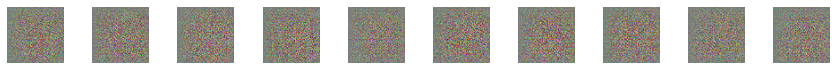

/root/anaconda3/envs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [-20.981667, -63.178185, 36.9931, 0.5203419] -42.575314


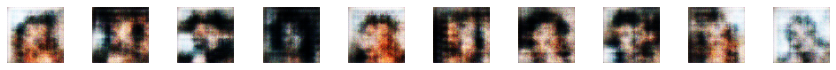

200 [-12.669468, -47.290077, 33.23205, 0.13885574] -34.788418


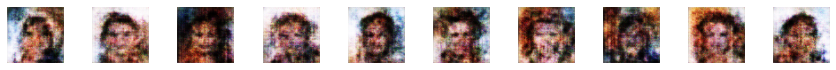

300 [-10.619723, -140.68695, 128.03532, 0.2031903] -126.38465


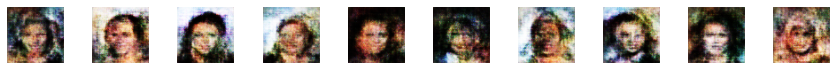

400 [-11.828591, -127.48973, 113.77039, 0.18907458] -106.630615


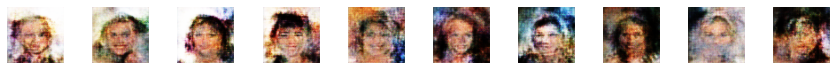

500 [-8.990855, -78.72199, 68.322624, 0.14085127] -61.959328


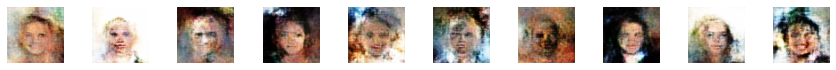

600 [-13.934909, -61.410862, 44.737076, 0.27388772] -50.110657


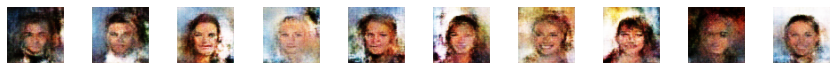

700 [-11.798182, -39.93071, 26.299345, 0.18331838] -27.36366


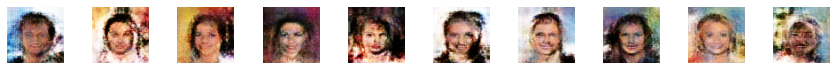

800 [-10.971865, -20.228409, 6.8858576, 0.23706862] -8.096749


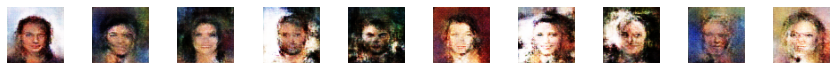

900 [-11.649309, -25.6985, 11.738304, 0.23108861] -7.460773


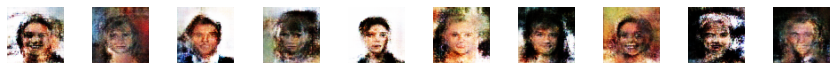

1000 [-11.195509, -24.536303, 11.467411, 0.18733823] -13.629778


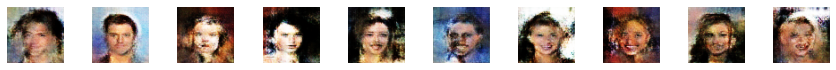

1100 [-10.631626, -6.8468485, -5.800343, 0.20155658] 2.6630936


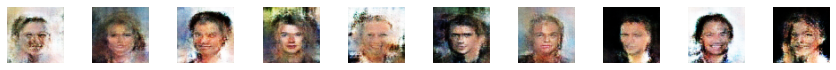

1200 [-10.030669, -6.822995, -4.9970126, 0.17893384] 1.7125702


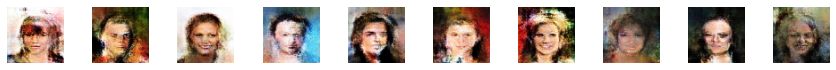

1300 [-9.942049, -7.627811, -4.4803214, 0.21660832] 0.23775613


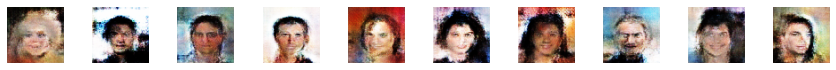

1400 [-11.0721655, -9.708504, -3.163397, 0.1799735] 4.5890603


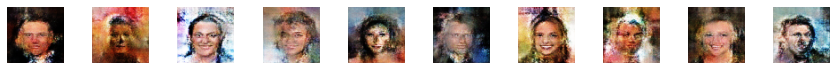

1500 [-10.68103, -12.06229, 0.10131162, 0.12799485] -0.18111247


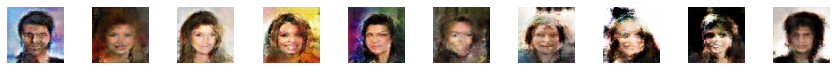

1600 [-9.626675, -5.4061427, -5.635674, 0.14151418] 7.9618526


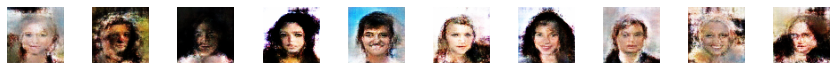

1700 [-10.266424, -9.375148, -2.7946393, 0.19033635] 4.555369


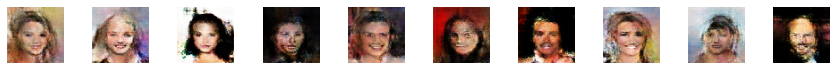

1800 [-10.053126, -3.9238658, -7.5685496, 0.14392895] 10.689308


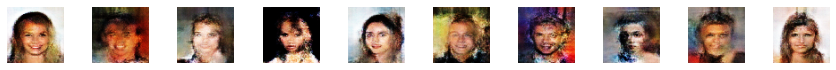

1900 [-8.793514, -6.6411676, -4.0634313, 0.19110852] 5.130861


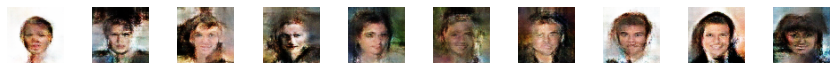

In [9]:
def train_cls():
    #真图,生成图,融合图,分别期望的计算结果
    real = np.ones((64, 1), dtype=np.float32)
    fake = -np.ones((64, 1), dtype=np.float32)
    merge = np.zeros((64, 1), dtype=np.float32)

    #取一批数据,如果是尾数,则重新取下一批
    batch_data = next(datas)[0]
    if batch_data.shape[0] != 64:
        batch_data = next(datas)[0]

    noise = np.random.normal(0, 1, (64, 100))

    return cls_model.train_on_batch([batch_data, noise], [real, fake, merge])


def train_gen():
    real = np.ones((64, 1), dtype=np.float32)
    noise = np.random.normal(0, 1, (64, 100))
    return gan.train_on_batch(noise, real)


def train():
    for epoch in range(2000):
        for _ in range(5):
            loss_cls = train_cls()

        loss_gen = train_gen()

        if epoch % 100 == 0:
            print(epoch, loss_cls, loss_gen)
            pred = gen.predict(np.random.normal(0, 1, (10, 100)))
            show(pred)


train()

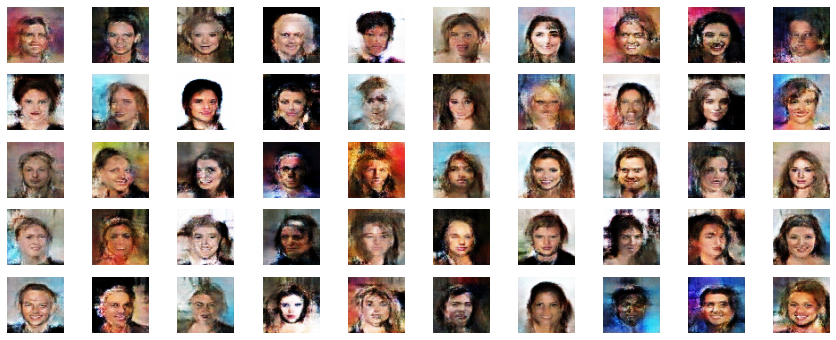

In [10]:
#生成
pred = gen.predict(np.random.randn(50, 100))

show(pred)